This notebook contains the second part of the implementation of the Euler-Bernoulli Beam using L1 error. In this notebook the Lambda values for the different error terms are optimized with optuna. The hyperparameters that were optimized in the first notebook are already implemented. In the end a final model is trained and used to predict displacement, velocity, acceleration and bending moment.

In [3]:
!pip install optuna
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 14.0 MB/s eta 0:00:00


In [4]:
def f_exact(x, t):
    return (1 - 16  * np.pi**2) * torch.sin(x) * torch.cos(4 * np.pi * t)

def u_exact(x, t):
    return torch.sin(x) * torch.cos(4 * np.pi * t)

In [5]:
def gen_data(L, t_end, n):
    x_vals = torch.rand(n) * L
    t_vals = torch.rand(n) * t_end
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals))

In [6]:
# training data generation
t_end = 1

x_gen, t_gen, f_gen, u_gen = gen_data(np.pi, t_end, 10000)
x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val = gen_data(np.pi, t_end, 1000)
x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)

/tmp/ipython-input-54349312.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
/tmp/ipython-input-54349312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)


In [7]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [9]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)

# Stack inputs (x, t, bias) and outputs (f, u) into N×3 and N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([f_gen, u_gen], dim=1).to(device)
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 3]
outputs_train = torch.stack([f_norm, u_norm], dim=1).to(device)  # Shape: [N, 2]
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 3]
outputs_val = torch.stack([f_val_norm, u_val_norm], dim=1).to(device)  # Shape: [N_val, 2]

batch_size = 300
validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [10]:
# save the normalizers to use in result file
torch.save({
    "x_mean": x_normalizer.normmean,
    "x_std": x_normalizer.normstd,
    "t_mean": t_normalizer.normmean,
    "t_std": t_normalizer.normstd,
    "u_mean": u_normalizer.normmean,
    "u_std": u_normalizer.normstd,
}, "normalizers_Euler_L1.pt")

# Model Definition

In [11]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = F.tanh(layer(x))    # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [12]:
# Define parameters
L = np.pi
T_end = 1

# Set sample sizes
N_f = 10000 # collocation points in interior
N_ic = 2000 # initial condition samples at t=0
N_bc = 2000 # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 150

# echo on screen
echo_every = 30

In [13]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            pred = model(inputs)
            # Extract only the u component from the target (second column) and unsqueeze to match pred shape
            target_u = target[:, 1].unsqueeze(1)
            loss = loss_function(pred, target_u)
            losses.append(loss.detach().item())

    return np.array(losses).mean()

In [14]:
def objective(trial):

    hidden_size = 400
    optimiser = torch.optim.AdamW
    learning_rate = 0.0011559206131664627
    num_layers = 1
    lambda_data = trial.suggest_float('lambda_data', 0.05, 1)
    lambda_ic = trial.suggest_float('lambda_ic', 0.05, 1)
    lambda_bc = trial.suggest_float('lambda_bc', 1, 10, log=True)
    lambda_physics = trial.suggest_float('lambda_physics', 0.05, 1)

    pinn = MLP(2, hidden_size, 1, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.AdamW(pinn.parameters(), lr=learning_rate)

    max_trial_seconds = 120  # e.g., 2 minutes per trial

    start_time = time.perf_counter()


    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        # Use the pre-stacked inputs_train for pinn input
        u_pred_data = pinn(inputs_train)
        # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
        target_u_norm = outputs_train[:, 1].unsqueeze(1)
        loss_data = torch.mean(torch.abs(u_pred_data - target_u_norm))

        # initial condition
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_ic_1 = torch.mean(torch.abs(u - torch.sin(x_ic)))
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_ic_2 = torch.mean(torch.abs(dudt - 0))

        # boundary condition left
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_left_1 = torch.mean(torch.abs(u - 0))
        dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
        loss_bc_left_2 = torch.mean(torch.abs(d2udx2_bc_left - 0))


        # boundary condition right
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_right_1 = torch.mean(torch.abs(u - 0))
        dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
        loss_bc_right_2 = torch.mean(torch.abs(d2udx2_bc_right - 0))

        # compute physics loss
        EI = 1
        rhoA = 1
        u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
        u_f_denorm = u_normalizer.denormalize(u_f)
        u_f = u_f_denorm

        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
        d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
        loss_physics = torch.mean(torch.abs(physics_residual))

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())

        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            print(f"Epoch {i}: total loss = {loss:.6f}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data:.6f}, loss_ic_1 = {loss_ic_1:.6f}, loss_ic_2 = {loss_ic_2:.6f}, loss_bc_left_1 = {loss_bc_left_1:.6f}, loss_bc_left_2 = {loss_bc_left_2:.6f}, loss_bc_right_1 = {loss_bc_right_1:.6f}, loss_bc_right_2 = {loss_bc_right_2:.6f}, loss_physics = {loss_physics:.6f}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")

            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()

        # Check if the trial has exceeded the maximum allowed time
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()


    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-01-29 16:03:04,945] A new study created in memory with name: no-name-c6402721-2696-48e1-b4b7-b868bd242b5a


Epoch 0: total loss = 24.134232, validation_loss = 1.207900, loss_data = 0.821956, loss_ic_1 = 0.778149, loss_ic_2 = 0.258637, loss_bc_left_1 = 0.084898, loss_bc_left_2 = 0.009467, loss_bc_right_1 = 0.067382, loss_bc_right_2 = 0.010642, loss_physics = 63.685822
Validation loss at epoch 0: 1.207900
Epoch 30: total loss = 23.417608, validation_loss = 0.869776, loss_data = 0.805384, loss_ic_1 = 0.613819, loss_ic_2 = 0.087040, loss_bc_left_1 = 0.046782, loss_bc_left_2 = 0.009813, loss_bc_right_1 = 0.016183, loss_bc_right_2 = 0.005646, loss_physics = 63.441692
Validation loss at epoch 30: 0.869776
Epoch 60: total loss = 23.054934, validation_loss = 0.855441, loss_data = 0.796305, loss_ic_1 = 0.574464, loss_ic_2 = 0.093568, loss_bc_left_1 = 0.024755, loss_bc_left_2 = 0.006259, loss_bc_right_1 = 0.040444, loss_bc_right_2 = 0.002886, loss_physics = 62.526947
Validation loss at epoch 60: 0.855441
Epoch 90: total loss = 21.622877, validation_loss = 0.804483, loss_data = 0.749976, loss_ic_1 = 0.5

[I 2026-01-29 16:03:41,638] Trial 0 finished with value: 0.6502812206745148 and parameters: {'lambda_data': 0.5773078781845461, 'lambda_ic': 0.5724949568299861, 'lambda_bc': 4.569123932492274, 'lambda_physics': 0.34981858689808837}. Best is trial 0 with value: 0.6502812206745148.


Epoch 150: total loss = 16.843086, validation_loss = 0.650281, loss_data = 0.616600, loss_ic_1 = 0.552156, loss_ic_2 = 0.072320, loss_bc_left_1 = 0.119991, loss_bc_left_2 = 0.012955, loss_bc_right_1 = 0.121480, loss_bc_right_2 = 0.018399, loss_physics = 42.545013
Validation loss at epoch 150: 0.650281
  Params: 
    lambda_data: 0.5773078781845461
    lambda_ic: 0.5724949568299861
    lambda_bc: 4.569123932492274
    lambda_physics: 0.34981858689808837
Epoch 0: total loss = 7.781627, validation_loss = 1.269249, loss_data = 0.824978, loss_ic_1 = 0.547854, loss_ic_2 = 0.142311, loss_bc_left_1 = 0.103051, loss_bc_left_2 = 0.030720, loss_bc_right_1 = 0.063706, loss_bc_right_2 = 0.023210, loss_physics = 63.910973
Validation loss at epoch 0: 1.269249
Epoch 30: total loss = 7.177976, validation_loss = 0.871863, loss_data = 0.805163, loss_ic_1 = 0.635208, loss_ic_2 = 0.019842, loss_bc_left_1 = 0.023603, loss_bc_left_2 = 0.005786, loss_bc_right_1 = 0.024348, loss_bc_right_2 = 0.005530, loss_phy

[I 2026-01-29 16:04:05,590] Trial 1 finished with value: 0.8256306499242783 and parameters: {'lambda_data': 0.6686598092442214, 'lambda_ic': 0.24314912427395774, 'lambda_bc': 3.3635483272634685, 'lambda_physics': 0.09888581453870099}. Best is trial 0 with value: 0.6502812206745148.


Epoch 150: total loss = 6.846238, validation_loss = 0.825631, loss_data = 0.763440, loss_ic_1 = 0.608578, loss_ic_2 = 0.033731, loss_bc_left_1 = 0.020896, loss_bc_left_2 = 0.000844, loss_bc_right_1 = 0.021128, loss_bc_right_2 = 0.000977, loss_physics = 61.000687
Validation loss at epoch 150: 0.825631
  Params: 
    lambda_data: 0.6686598092442214
    lambda_ic: 0.24314912427395774
    lambda_bc: 3.3635483272634685
    lambda_physics: 0.09888581453870099
Epoch 0: total loss = 40.132298, validation_loss = 1.322292, loss_data = 0.815274, loss_ic_1 = 0.592414, loss_ic_2 = 0.042824, loss_bc_left_1 = 0.035455, loss_bc_left_2 = 0.010414, loss_bc_right_1 = 0.078338, loss_bc_right_2 = 0.008097, loss_physics = 63.100731
Validation loss at epoch 0: 1.322292
Epoch 30: total loss = 40.072945, validation_loss = 0.870978, loss_data = 0.808526, loss_ic_1 = 0.645082, loss_ic_2 = 0.013981, loss_bc_left_1 = 0.052518, loss_bc_left_2 = 0.017069, loss_bc_right_1 = 0.037698, loss_bc_right_2 = 0.011536, loss_

[I 2026-01-29 16:04:29,961] Trial 2 finished with value: 0.6928921341896057 and parameters: {'lambda_data': 0.16354021921380302, 'lambda_ic': 0.7730562748871495, 'lambda_bc': 9.619876216650072, 'lambda_physics': 0.6059382684383553}. Best is trial 0 with value: 0.6502812206745148.


Epoch 150: total loss = 31.737568, validation_loss = 0.692892, loss_data = 0.646270, loss_ic_1 = 0.598091, loss_ic_2 = 0.043227, loss_bc_left_1 = 0.097097, loss_bc_left_2 = 0.006229, loss_bc_right_1 = 0.098435, loss_bc_right_2 = 0.011004, loss_physics = 48.007080
Validation loss at epoch 150: 0.692892
  Params: 
    lambda_data: 0.16354021921380302
    lambda_ic: 0.7730562748871495
    lambda_bc: 9.619876216650072
    lambda_physics: 0.6059382684383553
Epoch 0: total loss = 14.258028, validation_loss = 1.147803, loss_data = 0.817745, loss_ic_1 = 0.506930, loss_ic_2 = 0.130038, loss_bc_left_1 = 0.063358, loss_bc_left_2 = 0.006875, loss_bc_right_1 = 0.046444, loss_bc_right_2 = 0.006944, loss_physics = 63.761948
Validation loss at epoch 0: 1.147803
Epoch 30: total loss = 14.391965, validation_loss = 0.877373, loss_data = 0.817720, loss_ic_1 = 0.513924, loss_ic_2 = 0.109647, loss_bc_left_1 = 0.044953, loss_bc_left_2 = 0.004942, loss_bc_right_1 = 0.068167, loss_bc_right_2 = 0.011221, loss_p

[I 2026-01-29 16:04:55,039] Trial 3 finished with value: 0.8701590299606323 and parameters: {'lambda_data': 0.12605881158180343, 'lambda_ic': 0.19616466691929196, 'lambda_bc': 9.150360279442202, 'lambda_physics': 0.20229637324355432}. Best is trial 0 with value: 0.6502812206745148.


Epoch 150: total loss = 13.345959, validation_loss = 0.870159, loss_data = 0.802570, loss_ic_1 = 0.661003, loss_ic_2 = 0.016397, loss_bc_left_1 = 0.003087, loss_bc_left_2 = 0.006128, loss_bc_right_1 = 0.031299, loss_bc_right_2 = 0.001998, loss_physics = 62.892448
Validation loss at epoch 150: 0.870159
  Params: 
    lambda_data: 0.12605881158180343
    lambda_ic: 0.19616466691929196
    lambda_bc: 9.150360279442202
    lambda_physics: 0.20229637324355432
Epoch 0: total loss = 59.807652, validation_loss = 1.334612, loss_data = 0.809227, loss_ic_1 = 0.652129, loss_ic_2 = 0.053397, loss_bc_left_1 = 0.029876, loss_bc_left_2 = 0.011030, loss_bc_right_1 = 0.046514, loss_bc_right_2 = 0.020720, loss_physics = 63.716187
Validation loss at epoch 0: 1.334612
Epoch 30: total loss = 57.678791, validation_loss = 0.844075, loss_data = 0.786367, loss_ic_1 = 0.632421, loss_ic_2 = 0.087197, loss_bc_left_1 = 0.033516, loss_bc_left_2 = 0.016720, loss_bc_right_1 = 0.068813, loss_bc_right_2 = 0.007672, loss

[I 2026-01-29 16:05:19,934] Trial 4 finished with value: 0.3759743720293045 and parameters: {'lambda_data': 0.45325187001999445, 'lambda_ic': 0.7524917921335279, 'lambda_bc': 2.502104680433831, 'lambda_physics': 0.9203217237683913}. Best is trial 4 with value: 0.3759743720293045.


Epoch 150: total loss = 7.301347, validation_loss = 0.375974, loss_data = 0.385307, loss_ic_1 = 0.212207, loss_ic_2 = 0.731136, loss_bc_left_1 = 0.191940, loss_bc_left_2 = 0.080334, loss_bc_right_1 = 0.194668, loss_bc_right_2 = 0.104917, loss_physics = 5.417666
Validation loss at epoch 150: 0.375974
  Params: 
    lambda_data: 0.45325187001999445
    lambda_ic: 0.7524917921335279
    lambda_bc: 2.502104680433831
    lambda_physics: 0.9203217237683913
Epoch 0: total loss = 45.040485, validation_loss = 1.168116, loss_data = 0.824679, loss_ic_1 = 0.850553, loss_ic_2 = 0.258802, loss_bc_left_1 = 0.076656, loss_bc_left_2 = 0.017675, loss_bc_right_1 = 0.089046, loss_bc_right_2 = 0.006340, loss_physics = 63.713978
Validation loss at epoch 0: 1.168116
Epoch 30: total loss = 44.114548, validation_loss = 0.882279, loss_data = 0.813287, loss_ic_1 = 0.545629, loss_ic_2 = 0.103116, loss_bc_left_1 = 0.037930, loss_bc_left_2 = 0.014966, loss_bc_right_1 = 0.060396, loss_bc_right_2 = 0.009227, loss_phy

[I 2026-01-29 16:05:44,884] Trial 5 finished with value: 0.6043896973133087 and parameters: {'lambda_data': 0.4046955520957373, 'lambda_ic': 0.7308251917192199, 'lambda_bc': 7.458031857378372, 'lambda_physics': 0.6667467228720945}. Best is trial 4 with value: 0.3759743720293045.


Epoch 150: total loss = 29.974651, validation_loss = 0.604390, loss_data = 0.575545, loss_ic_1 = 0.518189, loss_ic_2 = 0.083080, loss_bc_left_1 = 0.122591, loss_bc_left_2 = 0.014798, loss_bc_right_1 = 0.118404, loss_bc_right_2 = 0.020004, loss_physics = 40.863209
Validation loss at epoch 150: 0.604390
  Params: 
    lambda_data: 0.4046955520957373
    lambda_ic: 0.7308251917192199
    lambda_bc: 7.458031857378372
    lambda_physics: 0.6667467228720945
Epoch 0: total loss = 24.889341, validation_loss = 1.194280, loss_data = 0.823984, loss_ic_1 = 0.744742, loss_ic_2 = 0.036085, loss_bc_left_1 = 0.081433, loss_bc_left_2 = 0.011613, loss_bc_right_1 = 0.097292, loss_bc_right_2 = 0.012350, loss_physics = 64.091675
Validation loss at epoch 0: 1.194280


[I 2026-01-29 16:05:49,939] Trial 6 pruned. 


Epoch 30: total loss = 24.099463, validation_loss = 0.880438, loss_data = 0.809388, loss_ic_1 = 0.720076, loss_ic_2 = 0.021969, loss_bc_left_1 = 0.044917, loss_bc_left_2 = 0.004488, loss_bc_right_1 = 0.065166, loss_bc_right_2 = 0.001711, loss_physics = 63.928162
Validation loss at epoch 30: 0.880438
 (Pruned) Params: 
    lambda_data: 0.6009878249541335
    lambda_ic: 0.4896453578579074
    lambda_bc: 8.160118313706201
    lambda_physics: 0.3488418238234433
Epoch 0: total loss = 34.047382, validation_loss = 1.128306, loss_data = 0.836909, loss_ic_1 = 0.554808, loss_ic_2 = 0.250509, loss_bc_left_1 = 0.083042, loss_bc_left_2 = 0.009423, loss_bc_right_1 = 0.099174, loss_bc_right_2 = 0.015630, loss_physics = 63.950722
Validation loss at epoch 0: 1.128306


[I 2026-01-29 16:05:55,247] Trial 7 pruned. 


Epoch 30: total loss = 33.834873, validation_loss = 0.874917, loss_data = 0.808534, loss_ic_1 = 0.630124, loss_ic_2 = 0.150986, loss_bc_left_1 = 0.041757, loss_bc_left_2 = 0.006241, loss_bc_right_1 = 0.065002, loss_bc_right_2 = 0.004729, loss_physics = 64.232422
Validation loss at epoch 30: 0.874917
 (Pruned) Params: 
    lambda_data: 0.09068412566443863
    lambda_ic: 0.21808266720564468
    lambda_bc: 3.908373777343457
    lambda_physics: 0.5157999552412631
Epoch 0: total loss = 39.826805, validation_loss = 1.304603, loss_data = 0.815075, loss_ic_1 = 0.742256, loss_ic_2 = 0.144550, loss_bc_left_1 = 0.067222, loss_bc_left_2 = 0.029167, loss_bc_right_1 = 0.067025, loss_bc_right_2 = 0.018312, loss_physics = 63.293549
Validation loss at epoch 0: 1.304603
Epoch 30: total loss = 36.067375, validation_loss = 0.802816, loss_data = 0.749886, loss_ic_1 = 0.689222, loss_ic_2 = 0.266740, loss_bc_left_1 = 0.093183, loss_bc_left_2 = 0.019863, loss_bc_right_1 = 0.074941, loss_bc_right_2 = 0.010350,

[I 2026-01-29 16:06:19,996] Trial 8 finished with value: 0.18917369097471237 and parameters: {'lambda_data': 0.4648532881077968, 'lambda_ic': 0.11997366781931738, 'lambda_bc': 1.000449449454854, 'lambda_physics': 0.6186999040512667}. Best is trial 8 with value: 0.18917369097471237.


Epoch 150: total loss = 2.265986, validation_loss = 0.189174, loss_data = 0.180680, loss_ic_1 = 0.208258, loss_ic_2 = 0.290407, loss_bc_left_1 = 0.066746, loss_bc_left_2 = 0.078765, loss_bc_right_1 = 0.080708, loss_bc_right_2 = 0.110288, loss_physics = 2.885907
Validation loss at epoch 150: 0.189174
  Params: 
    lambda_data: 0.4648532881077968
    lambda_ic: 0.11997366781931738
    lambda_bc: 1.000449449454854
    lambda_physics: 0.6186999040512667
Epoch 0: total loss = 51.060585, validation_loss = 1.267474, loss_data = 0.829647, loss_ic_1 = 0.670494, loss_ic_2 = 0.096136, loss_bc_left_1 = 0.145468, loss_bc_left_2 = 0.043794, loss_bc_right_1 = 0.104212, loss_bc_right_2 = 0.046256, loss_physics = 63.466949
Validation loss at epoch 0: 1.267474
Epoch 30: total loss = 46.915676, validation_loss = 0.812314, loss_data = 0.758695, loss_ic_1 = 0.622367, loss_ic_2 = 0.125515, loss_bc_left_1 = 0.098325, loss_bc_left_2 = 0.011253, loss_bc_right_1 = 0.082203, loss_bc_right_2 = 0.022288, loss_phy

[I 2026-01-29 16:06:44,711] Trial 9 finished with value: 0.1390988826751709 and parameters: {'lambda_data': 0.9902614384604604, 'lambda_ic': 0.49629543613953414, 'lambda_bc': 1.5322639669621976, 'lambda_physics': 0.7773807513239699}. Best is trial 9 with value: 0.1390988826751709.


Epoch 150: total loss = 3.019803, validation_loss = 0.139099, loss_data = 0.165433, loss_ic_1 = 0.121426, loss_ic_2 = 0.280360, loss_bc_left_1 = 0.075279, loss_bc_left_2 = 0.075310, loss_bc_right_1 = 0.102138, loss_bc_right_2 = 0.068308, loss_physics = 2.784562
Validation loss at epoch 150: 0.139099
  Params: 
    lambda_data: 0.9902614384604604
    lambda_ic: 0.49629543613953414
    lambda_bc: 1.5322639669621976
    lambda_physics: 0.7773807513239699
Epoch 0: total loss = 63.491013, validation_loss = 1.285932, loss_data = 0.807063, loss_ic_1 = 0.625017, loss_ic_2 = 0.029935, loss_bc_left_1 = 0.030328, loss_bc_left_2 = 0.014600, loss_bc_right_1 = 0.017394, loss_bc_right_2 = 0.012969, loss_physics = 62.854324
Validation loss at epoch 0: 1.285932
Epoch 30: total loss = 55.162022, validation_loss = 0.776358, loss_data = 0.721875, loss_ic_1 = 0.666279, loss_ic_2 = 0.018743, loss_bc_left_1 = 0.099487, loss_bc_left_2 = 0.012441, loss_bc_right_1 = 0.102301, loss_bc_right_2 = 0.014706, loss_ph

[I 2026-01-29 16:07:09,477] Trial 10 finished with value: 0.11550165340304375 and parameters: {'lambda_data': 0.9705706109329769, 'lambda_ic': 0.9929679228821506, 'lambda_bc': 1.4020930346930516, 'lambda_physics': 0.9856408373482639}. Best is trial 10 with value: 0.11550165340304375.


Epoch 150: total loss = 3.801631, validation_loss = 0.115502, loss_data = 0.123528, loss_ic_1 = 0.072189, loss_ic_2 = 0.513493, loss_bc_left_1 = 0.068678, loss_bc_left_2 = 0.130868, loss_bc_right_1 = 0.094467, loss_bc_right_2 = 0.078776, loss_physics = 2.615039
Validation loss at epoch 150: 0.115502
  Params: 
    lambda_data: 0.9705706109329769
    lambda_ic: 0.9929679228821506
    lambda_bc: 1.4020930346930516
    lambda_physics: 0.9856408373482639
Epoch 0: total loss = 63.616978, validation_loss = 1.333815, loss_data = 0.816622, loss_ic_1 = 0.651344, loss_ic_2 = 0.017595, loss_bc_left_1 = 0.037599, loss_bc_left_2 = 0.035627, loss_bc_right_1 = 0.108496, loss_bc_right_2 = 0.023347, loss_physics = 63.517094
Validation loss at epoch 0: 1.333815
Epoch 30: total loss = 55.864002, validation_loss = 0.801950, loss_data = 0.745442, loss_ic_1 = 0.671042, loss_ic_2 = 0.137428, loss_bc_left_1 = 0.095258, loss_bc_left_2 = 0.017286, loss_bc_right_1 = 0.104348, loss_bc_right_2 = 0.008815, loss_phy

[I 2026-01-29 16:07:34,410] Trial 11 finished with value: 0.12332875840365887 and parameters: {'lambda_data': 0.9816458923916008, 'lambda_ic': 0.9274028673205622, 'lambda_bc': 1.303057994414102, 'lambda_physics': 0.9749777483135317}. Best is trial 10 with value: 0.11550165340304375.


Epoch 150: total loss = 4.042146, validation_loss = 0.123329, loss_data = 0.133065, loss_ic_1 = 0.161620, loss_ic_2 = 0.287086, loss_bc_left_1 = 0.107113, loss_bc_left_2 = 0.139392, loss_bc_right_1 = 0.113160, loss_bc_right_2 = 0.101138, loss_physics = 2.969235
Validation loss at epoch 150: 0.123329
  Params: 
    lambda_data: 0.9816458923916008
    lambda_ic: 0.9274028673205622
    lambda_bc: 1.303057994414102
    lambda_physics: 0.9749777483135317
Epoch 0: total loss = 65.035629, validation_loss = 1.277954, loss_data = 0.824903, loss_ic_1 = 0.772059, loss_ic_2 = 0.008932, loss_bc_left_1 = 0.037335, loss_bc_left_2 = 0.023089, loss_bc_right_1 = 0.159398, loss_bc_right_2 = 0.021734, loss_physics = 63.191662
Validation loss at epoch 0: 1.277954
Epoch 30: total loss = 61.670200, validation_loss = 0.821772, loss_data = 0.762435, loss_ic_1 = 0.638862, loss_ic_2 = 0.069812, loss_bc_left_1 = 0.036759, loss_bc_left_2 = 0.006065, loss_bc_right_1 = 0.038248, loss_bc_right_2 = 0.010914, loss_phys

[I 2026-01-29 16:07:59,126] Trial 12 finished with value: 0.11313395947217941 and parameters: {'lambda_data': 0.9821631549033996, 'lambda_ic': 0.9925490807831969, 'lambda_bc': 1.6938383787819564, 'lambda_physics': 0.9976175560686849}. Best is trial 12 with value: 0.11313395947217941.


Epoch 150: total loss = 4.358755, validation_loss = 0.113134, loss_data = 0.111810, loss_ic_1 = 0.202045, loss_ic_2 = 0.258161, loss_bc_left_1 = 0.111352, loss_bc_left_2 = 0.113502, loss_bc_right_1 = 0.124290, loss_bc_right_2 = 0.113101, loss_physics = 3.016382
Validation loss at epoch 150: 0.113134
  Params: 
    lambda_data: 0.9821631549033996
    lambda_ic: 0.9925490807831969
    lambda_bc: 1.6938383787819564
    lambda_physics: 0.9976175560686849
Epoch 0: total loss = 56.483833, validation_loss = 1.187888, loss_data = 0.809307, loss_ic_1 = 0.735602, loss_ic_2 = 0.158726, loss_bc_left_1 = 0.035736, loss_bc_left_2 = 0.007713, loss_bc_right_1 = 0.047753, loss_bc_right_2 = 0.003430, loss_physics = 63.506134
Validation loss at epoch 0: 1.187888


[I 2026-01-29 16:08:04,203] Trial 13 pruned. 


Epoch 30: total loss = 55.228764, validation_loss = 0.848705, loss_data = 0.784553, loss_ic_1 = 0.617752, loss_ic_2 = 0.015840, loss_bc_left_1 = 0.029855, loss_bc_left_2 = 0.005547, loss_bc_right_1 = 0.036888, loss_bc_right_2 = 0.005250, loss_physics = 62.389248
Validation loss at epoch 30: 0.848705
 (Pruned) Params: 
    lambda_data: 0.8433453648024198
    lambda_ic: 0.9005167353039745
    lambda_bc: 2.085926308357524
    lambda_physics: 0.8628860997142199
Epoch 0: total loss = 52.392273, validation_loss = 1.230490, loss_data = 0.837866, loss_ic_1 = 0.448025, loss_ic_2 = 0.230367, loss_bc_left_1 = 0.109480, loss_bc_left_2 = 0.012322, loss_bc_right_1 = 0.100285, loss_bc_right_2 = 0.022023, loss_physics = 64.230911
Validation loss at epoch 0: 1.230490
Epoch 30: total loss = 48.835712, validation_loss = 0.838220, loss_data = 0.794706, loss_ic_1 = 0.498709, loss_ic_2 = 0.027616, loss_bc_left_1 = 0.102525, loss_bc_left_2 = 0.007308, loss_bc_right_1 = 0.093534, loss_bc_right_2 = 0.004875, l

[I 2026-01-29 16:08:28,955] Trial 14 finished with value: 0.18492595106363297 and parameters: {'lambda_data': 0.7973278038959373, 'lambda_ic': 0.9887282622109971, 'lambda_bc': 1.8167726520261012, 'lambda_physics': 0.7879381354446635}. Best is trial 12 with value: 0.11313395947217941.


Epoch 150: total loss = 5.362201, validation_loss = 0.184926, loss_data = 0.203612, loss_ic_1 = 0.266009, loss_ic_2 = 0.475910, loss_bc_left_1 = 0.157130, loss_bc_left_2 = 0.057090, loss_bc_right_1 = 0.153827, loss_bc_right_2 = 0.064983, loss_physics = 4.669886
Validation loss at epoch 150: 0.184926
  Params: 
    lambda_data: 0.7973278038959373
    lambda_ic: 0.9887282622109971
    lambda_bc: 1.8167726520261012
    lambda_physics: 0.7879381354446635
Epoch 0: total loss = 64.678802, validation_loss = 1.168431, loss_data = 0.819219, loss_ic_1 = 0.667013, loss_ic_2 = 0.183822, loss_bc_left_1 = 0.058311, loss_bc_left_2 = 0.011246, loss_bc_right_1 = 0.062225, loss_bc_right_2 = 0.008561, loss_physics = 63.392673
Validation loss at epoch 0: 1.168431
Epoch 30: total loss = 54.951153, validation_loss = 0.775210, loss_data = 0.732468, loss_ic_1 = 0.509950, loss_ic_2 = 0.073952, loss_bc_left_1 = 0.135110, loss_bc_left_2 = 0.028297, loss_bc_right_1 = 0.142629, loss_bc_right_2 = 0.016848, loss_phy

[I 2026-01-29 16:08:53,833] Trial 15 finished with value: 0.14789702370762825 and parameters: {'lambda_data': 0.8316299430257874, 'lambda_ic': 0.8580911440250703, 'lambda_bc': 1.0794958590690547, 'lambda_physics': 0.9956342953527285}. Best is trial 12 with value: 0.11313395947217941.


Epoch 150: total loss = 3.521088, validation_loss = 0.147897, loss_data = 0.146796, loss_ic_1 = 0.211676, loss_ic_2 = 0.272321, loss_bc_left_1 = 0.123921, loss_bc_left_2 = 0.138537, loss_bc_right_1 = 0.094790, loss_bc_right_2 = 0.171719, loss_physics = 2.423257
Validation loss at epoch 150: 0.147897
  Params: 
    lambda_data: 0.8316299430257874
    lambda_ic: 0.8580911440250703
    lambda_bc: 1.0794958590690547
    lambda_physics: 0.9956342953527285
Epoch 0: total loss = 48.633018, validation_loss = 1.256310, loss_data = 0.833655, loss_ic_1 = 0.508728, loss_ic_2 = 0.067663, loss_bc_left_1 = 0.045299, loss_bc_left_2 = 0.032166, loss_bc_right_1 = 0.150399, loss_bc_right_2 = 0.014762, loss_physics = 63.123150
Validation loss at epoch 0: 1.256310


[I 2026-01-29 16:08:58,935] Trial 16 pruned. 


Epoch 30: total loss = 47.335522, validation_loss = 0.858744, loss_data = 0.791874, loss_ic_1 = 0.679266, loss_ic_2 = 0.044412, loss_bc_left_1 = 0.064037, loss_bc_left_2 = 0.004544, loss_bc_right_1 = 0.038109, loss_bc_right_2 = 0.004793, loss_physics = 61.744755
Validation loss at epoch 30: 0.858744
 (Pruned) Params: 
    lambda_data: 0.7517003099111815
    lambda_ic: 0.6183269418283919
    lambda_bc: 2.516199081447771
    lambda_physics: 0.7452015366811349
Epoch 0: total loss = 58.518967, validation_loss = 1.198621, loss_data = 0.837249, loss_ic_1 = 0.572686, loss_ic_2 = 0.040794, loss_bc_left_1 = 0.092674, loss_bc_left_2 = 0.024286, loss_bc_right_1 = 0.173414, loss_bc_right_2 = 0.034645, loss_physics = 63.953724
Validation loss at epoch 0: 1.198621
Epoch 30: total loss = 54.541790, validation_loss = 0.831559, loss_data = 0.786229, loss_ic_1 = 0.553579, loss_ic_2 = 0.033550, loss_bc_left_1 = 0.067115, loss_bc_left_2 = 0.017502, loss_bc_right_1 = 0.103764, loss_bc_right_2 = 0.009253, l

[I 2026-01-29 16:09:09,157] Trial 17 pruned. 


Epoch 60: total loss = 35.498642, validation_loss = 0.792104, loss_data = 0.763449, loss_ic_1 = 0.575980, loss_ic_2 = 0.054715, loss_bc_left_1 = 0.221078, loss_bc_left_2 = 0.059223, loss_bc_right_1 = 0.216861, loss_bc_right_2 = 0.050024, loss_physics = 37.537941
Validation loss at epoch 60: 0.792104
 (Pruned) Params: 
    lambda_data: 0.9187713264169679
    lambda_ic: 0.9961624027606433
    lambda_bc: 1.7708574667466306
    lambda_physics: 0.8844369511586676
Epoch 0: total loss = 30.598103, validation_loss = 1.276755, loss_data = 0.816191, loss_ic_1 = 0.664076, loss_ic_2 = 0.170880, loss_bc_left_1 = 0.032596, loss_bc_left_2 = 0.019754, loss_bc_right_1 = 0.113246, loss_bc_right_2 = 0.014829, loss_physics = 62.860924
Validation loss at epoch 0: 1.276755


[I 2026-01-29 16:09:14,278] Trial 18 pruned. 


Epoch 30: total loss = 29.772520, validation_loss = 0.852033, loss_data = 0.798746, loss_ic_1 = 0.553354, loss_ic_2 = 0.049441, loss_bc_left_1 = 0.098748, loss_bc_left_2 = 0.007669, loss_bc_right_1 = 0.060438, loss_bc_right_2 = 0.014318, loss_physics = 61.310635
Validation loss at epoch 30: 0.852033
 (Pruned) Params: 
    lambda_data: 0.3465065684920926
    lambda_ic: 0.37537345998030136
    lambda_bc: 1.4473323444641435
    lambda_physics: 0.4731195319583096
Epoch 0: total loss = 55.778694, validation_loss = 1.253634, loss_data = 0.814378, loss_ic_1 = 0.664046, loss_ic_2 = 0.034047, loss_bc_left_1 = 0.095360, loss_bc_left_2 = 0.016813, loss_bc_right_1 = 0.019522, loss_bc_right_2 = 0.029294, loss_physics = 63.845055
Validation loss at epoch 0: 1.253634


[I 2026-01-29 16:09:19,398] Trial 19 pruned. 


Epoch 30: total loss = 54.732735, validation_loss = 0.863443, loss_data = 0.795092, loss_ic_1 = 0.646877, loss_ic_2 = 0.030904, loss_bc_left_1 = 0.015097, loss_bc_left_2 = 0.005417, loss_bc_right_1 = 0.038333, loss_bc_right_2 = 0.007140, loss_physics = 63.279194
Validation loss at epoch 30: 0.863443
 (Pruned) Params: 
    lambda_data: 0.6857911903289172
    lambda_ic: 0.6700262371475296
    lambda_bc: 5.705086772004207
    lambda_physics: 0.8431977119214883
Epoch 0: total loss = 46.271248, validation_loss = 1.148291, loss_data = 0.827308, loss_ic_1 = 0.649852, loss_ic_2 = 0.168861, loss_bc_left_1 = 0.029100, loss_bc_left_2 = 0.007599, loss_bc_right_1 = 0.132942, loss_bc_right_2 = 0.014017, loss_physics = 63.473362
Validation loss at epoch 0: 1.148291
Epoch 30: total loss = 42.654270, validation_loss = 0.823211, loss_data = 0.774678, loss_ic_1 = 0.536413, loss_ic_2 = 0.030836, loss_bc_left_1 = 0.077171, loss_bc_left_2 = 0.003328, loss_bc_right_1 = 0.071049, loss_bc_right_2 = 0.008542, l

[I 2026-01-29 16:09:45,181] Trial 20 finished with value: 0.14191631972789764 and parameters: {'lambda_data': 0.9077235626633184, 'lambda_ic': 0.8709676596547843, 'lambda_bc': 1.2139151183790742, 'lambda_physics': 0.7024090389596849}. Best is trial 12 with value: 0.11313395947217941.


Epoch 150: total loss = 4.035623, validation_loss = 0.141916, loss_data = 0.169384, loss_ic_1 = 0.269696, loss_ic_2 = 0.223490, loss_bc_left_1 = 0.113483, loss_bc_left_2 = 0.117028, loss_bc_right_1 = 0.128436, loss_bc_right_2 = 0.157265, loss_physics = 4.022844
Validation loss at epoch 150: 0.141916
  Params: 
    lambda_data: 0.9077235626633184
    lambda_ic: 0.8709676596547843
    lambda_bc: 1.2139151183790742
    lambda_physics: 0.7024090389596849
Epoch 0: total loss = 64.528282, validation_loss = 1.326994, loss_data = 0.805513, loss_ic_1 = 0.648312, loss_ic_2 = 0.070051, loss_bc_left_1 = 0.018317, loss_bc_left_2 = 0.007686, loss_bc_right_1 = 0.041458, loss_bc_right_2 = 0.010554, loss_physics = 63.106098
Validation loss at epoch 0: 1.326994


[I 2026-01-29 16:09:50,414] Trial 21 pruned. 


Epoch 30: total loss = 61.617939, validation_loss = 0.849904, loss_data = 0.790908, loss_ic_1 = 0.551392, loss_ic_2 = 0.018009, loss_bc_left_1 = 0.063886, loss_bc_left_2 = 0.013070, loss_bc_right_1 = 0.093500, loss_bc_right_2 = 0.008268, loss_physics = 60.202354
Validation loss at epoch 30: 0.849904
 (Pruned) Params: 
    lambda_data: 0.997709801732152
    lambda_ic: 0.9341541925262243
    lambda_bc: 1.3873739658837767
    lambda_physics: 0.9974522434344396
Epoch 0: total loss = 61.647991, validation_loss = 1.252757, loss_data = 0.807900, loss_ic_1 = 0.619533, loss_ic_2 = 0.047314, loss_bc_left_1 = 0.016695, loss_bc_left_2 = 0.007760, loss_bc_right_1 = 0.030927, loss_bc_right_2 = 0.014991, loss_physics = 63.473293
Validation loss at epoch 0: 1.252757


[I 2026-01-29 16:09:55,507] Trial 22 pruned. 


Epoch 30: total loss = 59.657661, validation_loss = 0.848268, loss_data = 0.790501, loss_ic_1 = 0.567467, loss_ic_2 = 0.019408, loss_bc_left_1 = 0.078277, loss_bc_left_2 = 0.005335, loss_bc_right_1 = 0.041313, loss_bc_right_2 = 0.006546, loss_physics = 61.328079
Validation loss at epoch 30: 0.848268
 (Pruned) Params: 
    lambda_data: 0.9189420485653476
    lambda_ic: 0.8153678633685861
    lambda_bc: 2.0625565279765996
    lambda_physics: 0.9486935143031614
Epoch 0: total loss = 54.576515, validation_loss = 1.265680, loss_data = 0.808125, loss_ic_1 = 0.612116, loss_ic_2 = 0.040828, loss_bc_left_1 = 0.047982, loss_bc_left_2 = 0.011447, loss_bc_right_1 = 0.032976, loss_bc_right_2 = 0.010514, loss_physics = 63.359493
Validation loss at epoch 0: 1.265680
Epoch 30: total loss = 48.158199, validation_loss = 0.784060, loss_data = 0.738630, loss_ic_1 = 0.577961, loss_ic_2 = 0.072600, loss_bc_left_1 = 0.101361, loss_bc_left_2 = 0.008565, loss_bc_right_1 = 0.098854, loss_bc_right_2 = 0.013753, 

[I 2026-01-29 16:10:20,566] Trial 23 finished with value: 0.15697728097438812 and parameters: {'lambda_data': 0.8958679404210853, 'lambda_ic': 0.9372617669808855, 'lambda_bc': 1.250890645023076, 'lambda_physics': 0.8382614657054832}. Best is trial 12 with value: 0.11313395947217941.


Epoch 150: total loss = 3.241857, validation_loss = 0.156977, loss_data = 0.137701, loss_ic_1 = 0.200450, loss_ic_2 = 0.110208, loss_bc_left_1 = 0.098711, loss_bc_left_2 = 0.077217, loss_bc_right_1 = 0.135173, loss_bc_right_2 = 0.091802, loss_physics = 2.771615
Validation loss at epoch 150: 0.156977
  Params: 
    lambda_data: 0.8958679404210853
    lambda_ic: 0.9372617669808855
    lambda_bc: 1.250890645023076
    lambda_physics: 0.8382614657054832
Epoch 0: total loss = 61.921398, validation_loss = 1.173622, loss_data = 0.834932, loss_ic_1 = 0.510181, loss_ic_2 = 0.045220, loss_bc_left_1 = 0.156201, loss_bc_left_2 = 0.021301, loss_bc_right_1 = 0.029044, loss_bc_right_2 = 0.011459, loss_physics = 64.435013
Validation loss at epoch 0: 1.173622


[I 2026-01-29 16:10:25,666] Trial 24 pruned. 


Epoch 30: total loss = 57.941830, validation_loss = 0.831970, loss_data = 0.780486, loss_ic_1 = 0.635099, loss_ic_2 = 0.062639, loss_bc_left_1 = 0.080376, loss_bc_left_2 = 0.015482, loss_bc_right_1 = 0.052915, loss_bc_right_2 = 0.005491, loss_physics = 60.226822
Validation loss at epoch 30: 0.831970
 (Pruned) Params: 
    lambda_data: 0.9981069062260393
    lambda_ic: 0.829098725968568
    lambda_bc: 1.6909566452485176
    lambda_physics: 0.9351891693741474
Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  10
  Number of complete trials:  15
Best trial:
  Value:  0.11313395947217941
  Params: 
    lambda_data: 0.9821631549033996
    lambda_ic: 0.9925490807831969
    lambda_bc: 1.6938383787819564
    lambda_physics: 0.9976175560686849


## Useful optuna plots

In [16]:
optuna.visualization.plot_param_importances(study)

In [17]:
optuna.visualization.plot_parallel_coordinate(study)

In [18]:
fig = optuna.visualization.plot_intermediate_values(study)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 2])

In [19]:
# train the model with the best hyperparameters
best_params = study.best_params

# Create a new model with the best parameters
hidden_size = 400
optimiser = torch.optim.AdamW
learning_rate = 0.0011559206131664627
num_layers = 1
lambda_data = best_params['lambda_data']
lambda_ic = best_params['lambda_ic']
lambda_bc = best_params['lambda_bc']
lambda_physics = best_params['lambda_physics']

pinn = MLP(2, hidden_size, 1, num_hid_layers=num_layers).to(device)
optimiser = torch.optim.AdamW(pinn.parameters(), lr=learning_rate)

n_epochs = 3000

best_loss = float('inf')
min_delta = 1e-6


for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    # Use the pre-stacked inputs_train for pinn input
    u_pred_data = pinn(inputs_train)
    # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
    target_u_norm = outputs_train[:, 1].unsqueeze(1)
    loss_data = torch.mean(torch.abs(u_pred_data - target_u_norm))

    # initial condition
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_ic_1 = torch.mean(torch.abs(u - torch.sin(x_ic)))
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_ic_2 = torch.mean(torch.abs(dudt - 0))

    # boundary condition left
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_left_1 = torch.mean(torch.abs(u - 0))
    dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
    loss_bc_left_2 = torch.mean(torch.abs(d2udx2_bc_left - 0))

    # boundary condition right
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_right_1 = torch.mean(torch.abs(u - 0))
    dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
    loss_bc_right_2 = torch.mean(torch.abs(d2udx2_bc_right - 0))

    # compute physics loss
    EI = 1
    rhoA = 1
    u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
    u_f_denorm = u_normalizer.denormalize(u_f)
    u_f = u_f_denorm

    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
    d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
    loss_physics = torch.mean(torch.abs(physics_residual))

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_Euler_L1")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_Euler_L1_temp")

    # plot the result as training progresses (no grad tracking)
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss:.6f}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data:.6f}, loss_ic_1 = {loss_ic_1:.6f}, loss_ic_2 = {loss_ic_2:.6f}, loss_bc_left_1 = {loss_bc_left_1:.6f}, loss_bc_left_2 = {loss_bc_left_2:.6f}, loss_bc_right_1 = {loss_bc_right_1:.6f}, loss_bc_right_2 = {loss_bc_right_2:.6f}, loss_physics = {loss_physics:.6f}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")

Epoch 0: total loss = 65.043167, validation_loss = 1.262363, loss_data = 0.814239, loss_ic_1 = 0.563034, loss_ic_2 = 0.072962, loss_bc_left_1 = 0.028708, loss_bc_left_2 = 0.011994, loss_bc_right_1 = 0.072649, loss_bc_right_2 = 0.010206, loss_physics = 63.554325
Validation loss at epoch 0: 1.262363
Epoch 100: total loss = 16.649654, validation_loss = 0.554724, loss_data = 0.585335, loss_ic_1 = 0.300214, loss_ic_2 = 0.754469, loss_bc_left_1 = 0.250723, loss_bc_left_2 = 0.160309, loss_bc_right_1 = 0.248351, loss_bc_right_2 = 0.172438, loss_physics = 13.651487
Validation loss at epoch 100: 0.554724
Epoch 200: total loss = 2.475699, validation_loss = 0.078456, loss_data = 0.059227, loss_ic_1 = 0.044328, loss_ic_2 = 0.223770, loss_bc_left_1 = 0.035902, loss_bc_left_2 = 0.039878, loss_bc_right_1 = 0.028102, loss_bc_right_2 = 0.064301, loss_physics = 1.871012
Validation loss at epoch 200: 0.078456
Epoch 300: total loss = 1.787715, validation_loss = 0.043067, loss_data = 0.036961, loss_ic_1 = 0

In [20]:
# Load the best model
pinn = MLP(2, 400, 1, num_hid_layers=1).to(device)
pinn.load_state_dict(torch.load("best_pinn_Euler_L1"))

<All keys matched successfully>

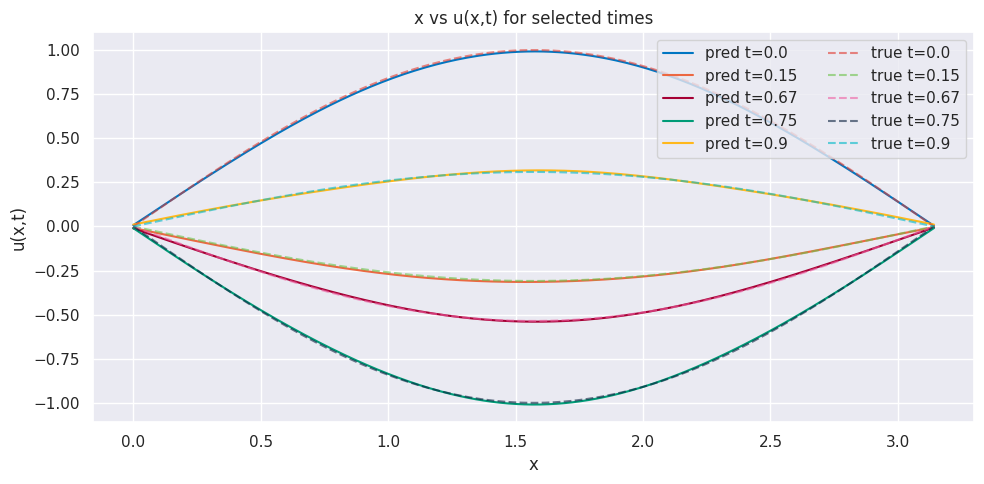

In [21]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot
plot_x_vs_u_at_times(pinn, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=300, L_val=L, with_exact=True)

In [22]:
Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

with torch.no_grad():
    u_n = pinn(torch.cat([xg_n, tg_n], dim=1))

u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)
u_true = u_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)
R_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")

Grid relative error (u):     1.124336%


In the following cells, the velocity, acceleration and bending moment are obtained from the beam deflection and compared to the analytical solutions.

In [24]:
#Velocity (first derivative of deflection with respect to time)
def velocity_exact(x,t):
  return - 4*np.pi* torch.sin(x) * torch.sin(4 * np.pi * t)

def compute_velocity(u_pred, t_tensor_with_grad): #Compute du/dt
    velo = torch.autograd.grad(
        outputs=u_pred,
        inputs=t_tensor_with_grad,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]
    return velo

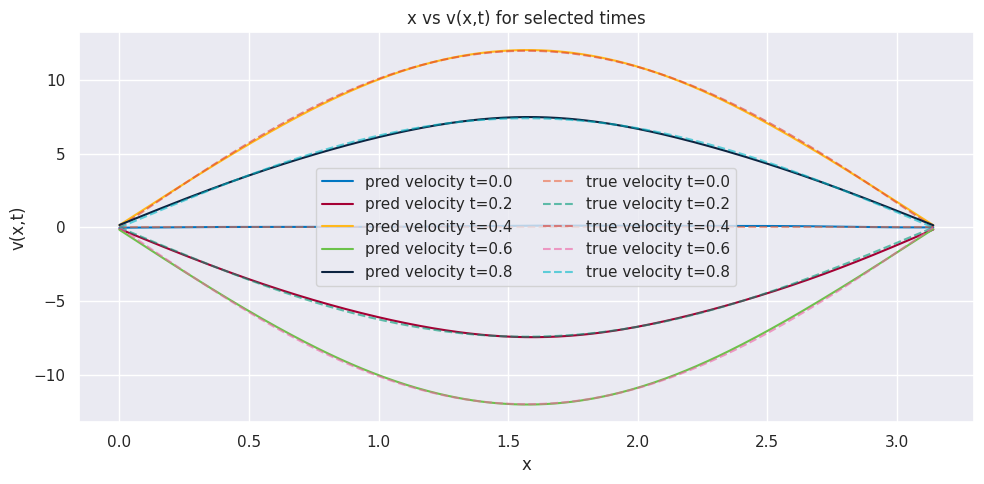

In [25]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_velocity(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)

    fig, ax = plt.subplots(figsize=(10,5))

    pred_handles = []
    pred_labels = []
    true_handles = []
    true_labels = []

    for t_val in times:
        # x values for plotting
        x_plot = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
        # t values for plotting
        t_plot = torch.full_like(x_plot, float(t_val)).to(device)

        # Prepare inputs for model and gradient calculation
        x_tensor_for_grad = x_plot.clone().detach().requires_grad_(True)
        t_tensor_for_grad = t_plot.clone().detach().requires_grad_(True)

        # Normalize inputs for the PINN model
        x_norm = x_normalizer.normalize(x_tensor_for_grad)
        t_norm = t_normalizer.normalize(t_tensor_for_grad)

        # Get u prediction from PINN
        u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
        u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)

        # Compute predicted velocity
        predicted_velocity = compute_velocity(u_pred_output_denorm, t_tensor_for_grad)

        # Plot predicted velocity
        pred_line, = ax.plot(x_plot.squeeze().cpu().numpy(), predicted_velocity.squeeze().cpu().detach().numpy(), label=f"pred velocity t={t_val}")
        pred_handles.append(pred_line)
        pred_labels.append(f"pred velocity t={t_val}")

        # exact solution overlay
        if with_exact and 'velocity_exact' in globals():
            true_velocity = velocity_exact(x_plot, t_plot).detach().cpu().squeeze()
            true_line, = ax.plot(x_plot.squeeze().cpu().numpy(), true_velocity.numpy(), '--', alpha=0.6, label=f"true velocity t={t_val}")
            true_handles.append(true_line)
            true_labels.append(f"true velocity t={t_val}")

    # Arrange handles and labels for a two-column legend: Column 1: all predictions, Column 2: all true values
    final_handles = pred_handles + true_handles
    final_labels = pred_labels + true_labels

    ax.set_xlabel('x')
    ax.set_ylabel('v(x,t)')
    ax.set_title('x vs v(x,t) for selected times')
    ax.legend(final_handles, final_labels, ncol=2)
    plt.tight_layout()
    plt.show()

# plot the velocities
plot_x_vs_velocity(pinn, times=(0.0, 0.2, 0.4, 0.6, 0.8), Nx=300, L_val=L, with_exact=True)

In [26]:
#Acceleration (second derivative of deflection with respect to time)
def acceleration_exact(x,t):
  return - 16*np.pi**2 * torch.sin(x) * torch.cos(4 * np.pi * t)

def compute_acceleration(u_pred, t_tensor_with_grad): #Compute d^2u/dt^2
    # First derivative
    du_dt = torch.autograd.grad(
        outputs=u_pred,
        inputs=t_tensor_with_grad,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    # Second derivative
    d2u_dt2 = torch.autograd.grad(
        outputs=du_dt,
        inputs=t_tensor_with_grad,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True,
        retain_graph=True
    )[0]

    return d2u_dt2

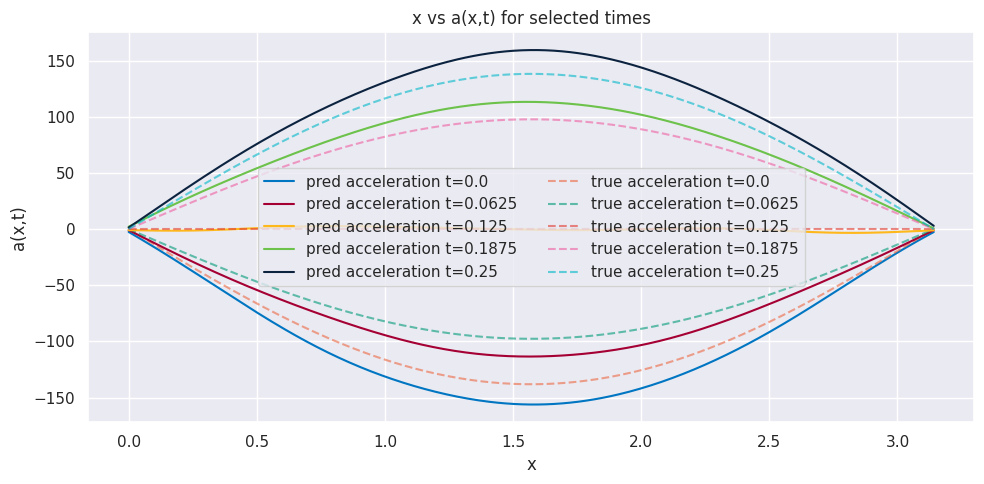

In [27]:
# Plot x vs a(x,t) for multiple time instants using the trained model

def plot_x_vs_acceleration(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)

    fig, ax = plt.subplots(figsize=(10,5))

    pred_handles = []
    pred_labels = []
    true_handles = []
    true_labels = []

    for t_val in times:
        # x values for plotting
        x_plot = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
        # t values for plotting
        t_plot = torch.full_like(x_plot, float(t_val)).to(device)

        # Prepare inputs for model and gradient calculation
        x_tensor_for_grad = x_plot.clone().detach().requires_grad_(True)
        t_tensor_for_grad = t_plot.clone().detach().requires_grad_(True)

        # Normalize inputs for the PINN model
        x_norm = x_normalizer.normalize(x_tensor_for_grad)
        t_norm = t_normalizer.normalize(t_tensor_for_grad)

        # Get u prediction from PINN
        u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
        u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)

        # Compute predicted acceleration
        predicted_acceleration = compute_acceleration(u_pred_output_denorm, t_tensor_for_grad)

        # Plot predicted acceleration
        pred_line, = ax.plot(x_plot.squeeze().cpu().numpy(), predicted_acceleration.squeeze().cpu().detach().numpy(), label=f"pred acceleration t={t_val}")
        pred_handles.append(pred_line)
        pred_labels.append(f"pred acceleration t={t_val}")

        # exact solution overlay
        if with_exact and 'acceleration_exact' in globals():
            true_acceleration = acceleration_exact(x_plot, t_plot).detach().cpu().squeeze()
            true_line, = ax.plot(x_plot.squeeze().cpu().numpy(), true_acceleration.numpy(), '--', alpha=0.6, label=f"true acceleration t={t_val}")
            true_handles.append(true_line)
            true_labels.append(f"true acceleration t={t_val}")

    # Arrange handles and labels for a two-column legend: Column 1: all predictions, Column 2: all true values
    final_handles = pred_handles + true_handles
    final_labels = pred_labels + true_labels

    ax.set_xlabel('x')
    ax.set_ylabel('a(x,t)')
    ax.set_title('x vs a(x,t) for selected times')
    ax.legend(final_handles, final_labels, ncol=2)
    plt.tight_layout()
    plt.show()

# plot the accelerations
plot_x_vs_acceleration(pinn, times=(0.0, 0.0625, 0.125, 0.1875, 0.25), Nx=300, L_val=L, with_exact=True)

In [28]:
#Bending moment (second derivative of deflection with respect to space multiplied with EI)
#M = -EI * d^2u/dx^2

def bending_moment_exact(x,t):
  return EI * torch.sin(x) * torch.cos(4 * np.pi * t)

def compute_bending_moment(u_pred, x_tensor_with_grad, EI):
    # First derivative wrt x
    du_dx = torch.autograd.grad(
        outputs=u_pred,
        inputs=x_tensor_with_grad,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    # Second derivative wrt x
    d2u_dx2 = torch.autograd.grad(
        outputs=du_dx,
        inputs=x_tensor_with_grad,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True,
        retain_graph=True
    )[0]

    M = -EI * d2u_dx2
    return M

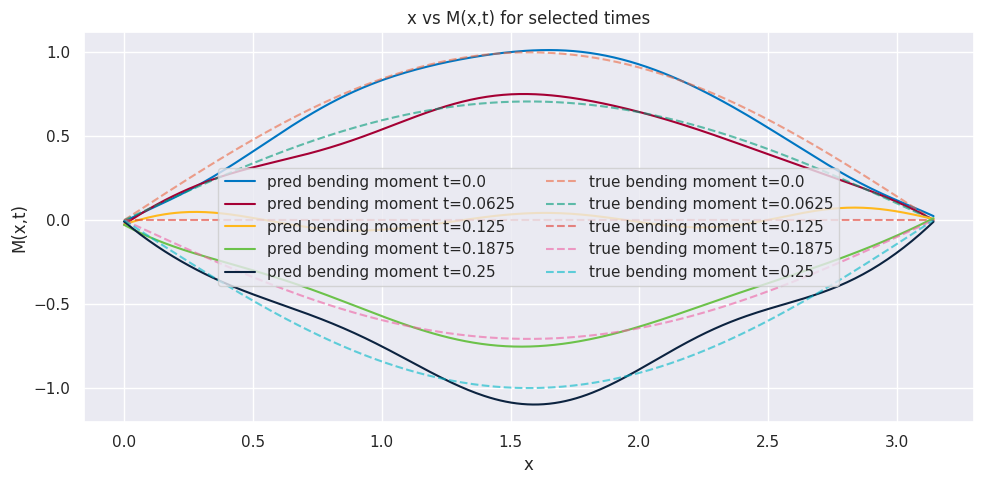

In [29]:
# Plot x vs M(x,t) for multiple time instants using the trained model

def plot_x_vs_bending_moment(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)

    fig, ax = plt.subplots(figsize=(10,5))

    pred_handles = []
    pred_labels = []
    true_handles = []
    true_labels = []

    for t_val in times:
        # x values for plotting
        x_plot = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
        # t values for plotting
        t_plot = torch.full_like(x_plot, float(t_val)).to(device)

        # Prepare inputs for model and gradient calculation
        x_tensor_for_grad = x_plot.clone().detach().requires_grad_(True)
        t_tensor_for_grad = t_plot.clone().detach().requires_grad_(True)

        # Normalize inputs for the PINN model
        x_norm = x_normalizer.normalize(x_tensor_for_grad)
        t_norm = t_normalizer.normalize(t_tensor_for_grad)

        # Get u prediction from PINN
        u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
        u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)

        # Compute predicted bending moment
        predicted_bending_moment = compute_bending_moment(u_pred_output_denorm, x_tensor_for_grad, 1)

        # Plot predicted bending moment
        pred_line, = ax.plot(x_plot.squeeze().cpu().numpy(), predicted_bending_moment.squeeze().cpu().detach().numpy(), label=f"pred bending moment t={t_val}")
        pred_handles.append(pred_line)
        pred_labels.append(f"pred bending moment t={t_val}")

        # exact solution overlay
        if with_exact and 'bending_moment_exact' in globals():
            true_bending_moment = bending_moment_exact(x_plot, t_plot).detach().cpu().squeeze()
            true_line, = ax.plot(x_plot.squeeze().cpu().numpy(), true_bending_moment.numpy(), '--', alpha=0.6, label=f"true bending moment t={t_val}")
            true_handles.append(true_line)
            true_labels.append(f"true bending moment t={t_val}")

    # Arrange handles and labels for a two-column legend: Column 1: all predictions, Column 2: all true values
    final_handles = pred_handles + true_handles
    final_labels = pred_labels + true_labels

    ax.set_xlabel('x')
    ax.set_ylabel('M(x,t)')
    ax.set_title('x vs M(x,t) for selected times')
    ax.legend(final_handles, final_labels, ncol=2)
    plt.tight_layout()
    plt.show()

# plot the bending moments
plot_x_vs_bending_moment(pinn, times=(0.0, 0.0625, 0.125, 0.1875, 0.25), Nx=300, L_val=L, with_exact=True)

In [30]:
import numpy as np
import torch

Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

u_n = pinn(torch.cat([xg_n, tg_n], dim=1))
u_denorm_tensor = u_normalizer.denormalize(u_n)
u_pred_numpy = u_denorm_tensor.detach().cpu().numpy().reshape(Nx, Nt)
u_true_numpy = u_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)

# Compute velocity, acceleration and bending moment, passing the denormalized u tensor and xg for bending moment
v_pred_tensor = compute_velocity(u_denorm_tensor, tg)
a_pred_tensor = compute_acceleration(u_denorm_tensor, tg)
M_pred_tensor = compute_bending_moment(u_denorm_tensor, xg, 1)

v_pred_numpy = v_pred_tensor.detach().cpu().numpy().reshape(Nx, Nt)
a_pred_numpy = a_pred_tensor.detach().cpu().numpy().reshape(Nx, Nt)
M_pred_numpy = M_pred_tensor.detach().cpu().numpy().reshape(Nx, Nt)

v_true_numpy = velocity_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)
a_true_numpy = acceleration_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)
M_true_numpy = bending_moment_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)

R_u = np.linalg.norm(u_pred_numpy - u_true_numpy) / np.linalg.norm(u_true_numpy) * 100
R_v = np.linalg.norm(v_pred_numpy - v_true_numpy) / np.linalg.norm(v_true_numpy) * 100
R_a = np.linalg.norm(a_pred_numpy - a_true_numpy) / np.linalg.norm(a_true_numpy) * 100
R_M = np.linalg.norm(M_pred_numpy - M_true_numpy) / np.linalg.norm(M_true_numpy) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")
print(f"Grid relative error (v):     {R_v:.6f}%")
print(f"Grid relative error (a):     {R_a:.6f}%")
print(f"Grid relative error (M):     {R_M:.6f}%")

Grid relative error (u):     1.124336%
Grid relative error (v):     1.204990%
Grid relative error (a):     14.474005%
Grid relative error (M):     10.145798%
